In [0]:
## Load in Autoencoder for creating adversarial examples 
## against different models. This particular code runs a 
## Sparse1Desecnt attack against the model. After doing this,
## this code computes the robustness of the trained network for the 
## validation set that it is using 


Mounted at /content/drive


In [0]:
import numpy as np
import tensorflow as tf
import six 
import math
from tensorflow.python.training import moving_averages 
import pickle
import tensorflow.keras.backend as K
from sklearn.preprocessing import normalize
import tensorflow_probability as tfp
CONT_FEATURE_SIZE = 158

In [0]:
## Constants for deciding how to add differential privacy to autoencoder 

NOISE_PLACEMENT = 'img_noise'
NOISE_SCHEME = 'l1_l1'
EPSILON = 1.0
DELTA_DP = 0.05
SCALE = 0.1
EPOCHS = 40 
NOISE = 0
BATCH_SIZE = 64
BATCH_SHAPE = 128
NOISE_TYPE = 'laplace'
AUTO_ENCODER_OUT_SHAPE = 158
FOLDER = 'USTC2-AutoEncoderLaplace'
NUM_CLASS =2
TRAIN =True 
SCALE_STRING = "0point1"

                        

In [0]:
## DP-Mult for different types of noise 
def dp_mult( size=None):
  epsilon_dp =EPSILON
  delta_dp   = DELTA_DP
  max_pixeldp_norm = SCALE
  if NOISE_SCHEME == 'l1_l2'    or  \
      NOISE_SCHEME == 'l2':
      return max_pixeldp_norm * \
          math.sqrt(2 * math.log(1.25 / delta_dp)) / epsilon_dp
  elif NOISE_SCHEME == 'l1_l1'  or  \
      NOISE_SCHEME == 'l1':
      return max_pixeldp_norm / epsilon_dp

In [0]:
## Create different types of noises for different 
## noise types and schemes
def img_dp_noise(shape):
  if NOISE_TYPE == 'laplace':
    sensitivity_multiplier = EPSILON 
    dp_mult_x = dp_mult()
    loc = tf.zeros([BATCH_SHAPE,shape])
    scale = tf.ones([BATCH_SHAPE,shape])
    epsilon = tfp.distributions.Laplace(loc,scale).sample()
    noise_scale = tf.placeholder(tf.float32,shape =(), name ='noise_scale')
    L1_SENSITIVITY = 1.0
    b = L1_SENSITIVITY *dp_mult_x*SCALE
    noise = b *epsilon
    
  elif NOISE_TYPE == 'gaussian':
    dp_mult_x = dp_mult()
    epsilon = tf.random_normal(shape=(BATCH_SHAPE,shape), mean=0,stddev=1)
    sensitivity_multiplier = EPSILON 
    L2_SENSITIVITY = 1.0
    noise_scale = tf.placeholder(tf.float32,shape =(), name ='noise_scale')
    SIGMA = tf.multiply(dp_mult_x,L2_SENSITIVITY,name= "SIGMA")
    noise_stddev = SCALE * SIGMA
    noise = noise_stddev *epsilon
  return noise

In [0]:
# Normalize the l1 direction https://github.com/columbia/pixeldp
def l1_normalize(x, dim, epsilon=1e-12, name=None):
  """Normalizes along dimension `dim` using an L1 norm.
  For a 1-D tensor with `dim = 0`, computes
      output = x / max(sum(abs(x)), epsilon)
  For `x` with more dimensions, independently normalizes each 1-D slice along
  dimension `dim`.
  Args:
    x: A `Tensor`.
    dim: Dimension along which to normalize.  A scalar or a vector of
      integers.
    epsilon: A lower bound value for the norm. Will use `sqrt(epsilon)` as the
      divisor if `norm < sqrt(epsilon)`.
    name: A name for this operation (optional).
  Returns:
    A `Tensor` with the same shape as `x`.
  """
  with tf.name_scope(name, "l1_normalize", [x]) as name:
    with tf.device("/gpu:0"):
      x          = tf.convert_to_tensor(x, name            = "x")
      abs_sum    = tf.reduce_sum(tf.abs(x), dim, keep_dims = True)
      x_inv_norm = tf.reciprocal(tf.maximum(abs_sum, epsilon))
      return tf.multiply(x, x_inv_norm, name=name)

In [0]:
with tf.device('/device:GPU:0'):
  NOISE = img_dp_noise(int(CONT_FEATURE_SIZE/2))
  ## Define the auto encoder without keras 
  x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,CONT_FEATURE_SIZE])
  y_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,CONT_FEATURE_SIZE])
  
  x2_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,AUTO_ENCODER_OUT_SHAPE])
  y2_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,2])
  y3_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,10])

In [0]:
## Load in the noise that was used to train the autoencoder
with open('./DP-GRAPHS/' + FOLDER+ '/NOISE'+SCALE_STRING, 'rb') as fp:
  NOISE = pickle.load(fp)
  fp.close()

In [0]:
## Get the autoencoder representation  
def get_rep(x, full_rep = True):
  with tf.variable_scope("first_model",reuse=tf.AUTO_REUSE):
    with tf.device('/device:GPU:0'):
    
      ## ADD NOISE 
      #noise_image = tf.add(NOISE,x) 
      W_dense1 = tf.get_variable("dense1",initializer =tf.random_normal(stddev=0.1, shape =[CONT_FEATURE_SIZE,int(CONT_FEATURE_SIZE/2)]))
      b_dense1 =  tf.get_variable("bias1",initializer =tf.random_normal(stddev=0.1, shape =[int(CONT_FEATURE_SIZE/2)]))
      if NOISE_SCHEME == "l1_l2":
        W_dense1_norm = tf.nn.l2_normalize(W_dense1,dim=1)
      else:
        W_dense1_norm = l1_normalize(W_dense1,dim=1)

      h_fc1 = tf.nn.relu(tf.matmul(tf.cast(x,tf.float32), W_dense1_norm))
      if TRAIN == True:
        noise_image = tf.add(h_fc1,NOISE)
      else:
        noise_image = tf.add(h_fc1,img_dp_noise(int(CONT_FEATURE_SIZE/2)))
      
      W_dense2 =tf.get_variable("dense2",initializer =tf.random_normal(stddev=0.1,shape= [int(CONT_FEATURE_SIZE/2),int(CONT_FEATURE_SIZE/4)]))
      b_dense2 = tf.get_variable("bias2",initializer =tf.random_normal(stddev=0.1,shape= [int(CONT_FEATURE_SIZE/4)]))
      h_fc2 = tf.nn.relu(tf.matmul(noise_image, W_dense2) + b_dense2)


      W_dense3 =tf.get_variable("dense3",initializer =tf.random_normal(stddev=0.1,shape= [int(CONT_FEATURE_SIZE/4),10]))
      b_dense3 =tf.get_variable("bias3",initializer =tf.random_normal(stddev=0.1,shape= [10])) 
      first_output = tf.matmul(h_fc2, W_dense3) + b_dense3
      h_fc3 = tf.nn.relu(first_output)

      W_dense4 =tf.get_variable("dense4",initializer =tf.random_normal(stddev=0.1,shape= [10,int(CONT_FEATURE_SIZE/4)]))
      b_dense4 =tf.get_variable("bias4",initializer =tf.random_normal(stddev=0.1,shape= [int(CONT_FEATURE_SIZE/4)]))
      h_fc4 = tf.nn.relu(tf.matmul(h_fc3, W_dense4) + b_dense4)

      W_dense5 = tf.get_variable("dense5",initializer =tf.random_normal(stddev=0.1,shape= [int(CONT_FEATURE_SIZE/4),int(CONT_FEATURE_SIZE/2)]))
      b_dense5 = tf.get_variable("bias5",initializer =tf.random_normal(stddev=0.1,shape= [int(CONT_FEATURE_SIZE/2)]))
      h_fc5 = tf.nn.relu(tf.matmul(h_fc4, W_dense5) + b_dense5)

      W_dense6 = tf.get_variable("dense6",initializer =tf.random_normal(stddev=0.1,shape= [int(CONT_FEATURE_SIZE/2),int(CONT_FEATURE_SIZE)]))
      b_dense6 = tf.get_variable("bias6",initializer =tf.random_normal(stddev=0.1,shape= [CONT_FEATURE_SIZE]))
      h_fc6 = tf.matmul(h_fc5, W_dense6) + b_dense6
      if full_rep == True:
        return h_fc6
      return first_output

In [0]:
## The CNN used to differentiate different types of flows 
def get_logits_cnn(x,return_embedding= False):
  with  tf.variable_scope("tree_second_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      W_dense4_class = tf.get_variable("dense4_sec",initializer =tf.random_normal(stddev=0.1, shape =[AUTO_ENCODER_OUT_SHAPE,784] ))
      b_dense4_class = tf.get_variable("bias4_sec",initializer =tf.random_normal(stddev=0.1,shape=[784]))
      h_fc4_class = tf.nn.relu(tf.matmul(tf.cast(x,tf.float32), W_dense4_class) + b_dense4_class)

      reshape_1_class = tf.reshape(h_fc4_class,[BATCH_SHAPE,28,28,1])
      conv2d_1_weight = tf.get_variable("conv2d_1_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 1, 32]))
      conv2d_1_bias = tf.get_variable("conv2d_1_bias",initializer =tf.random_normal(stddev=0.1, shape= [32]))
      conv2d_1_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(reshape_1_class,
                                                  conv2d_1_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_1_bias))

      maxpool2d_1_class = tf.nn.max_pool(conv2d_1_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')
      conv2d_2_weight = tf.get_variable("conv2d_2_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 32, 64]))
      conv2d_2_bias = tf.get_variable("conv2d_2_bias",initializer =tf.random_normal(stddev=0.1, shape=[64]))
      conv2d_2_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(maxpool2d_1_class,
                                                  conv2d_2_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_2_bias))

      maxpool2d_2_class = tf.nn.max_pool(conv2d_2_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')

      reshape_2_class = tf.reshape(maxpool2d_2_class,[BATCH_SHAPE,-1])
      drop_one = tf.nn.dropout(reshape_2_class,rate=0.2)
      W_dense5_class = tf.get_variable("dense5_sec",initializer =tf.random_normal(stddev=0.1,shape=[7*7*64,1024]))
      b_dense5_class = tf.get_variable("bias5_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024]))
      h_fc5_logit = tf.nn.bias_add(tf.matmul(drop_one, W_dense5_class),b_dense5_class)
      h_fc5_class = tf.nn.relu(h_fc5_logit)
      drop_two = tf.nn.dropout(h_fc5_class,rate=0.4)

      out_weight_class =  tf.get_variable("out_dense_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024, 2]))
      out_bias_class =  tf.get_variable("out_bias_sec",initializer =tf.random_normal(stddev=0.1,shape = [2]))
      out_final_logits = tf.nn.bias_add(tf.matmul(drop_two,out_weight_class),out_bias_class)
      if return_embedding == True:
        return h_fc5_logit
      return out_final_logits

In [0]:
def get_logits(x):
  return get_logits_cnn(get_rep(x, full_rep=True ))

In [0]:
with tf.device('/device:GPU:0'):

  mse = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_, predictions=get_rep(x_,True)))
  train_step = tf.train.AdamOptimizer(1e-4,name="adam-encoder").minimize(mse)
  accuracy = mse

W0808 12:13:46.738605 139739695155072 deprecation.py:506] From <ipython-input-9-ae2b94e09e25>:20: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0808 12:13:46.847620 139739695155072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
first_saver = tf.train.Saver()

In [0]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
print("GPU Available: ", tf.test.is_gpu_available())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU Available:  True
Found GPU at: /device:GPU:0


In [0]:
### Load in the data
with open('./embedding/CNN_FULL/USTC_rn_mal_meta_train', 'rb') as fp:
  mal_train_meta_X = pickle.load(fp)
  fp.close()
  
  
with open('./embedding/CNN_FULL/USTC_rn_mal_meta_valid', 'rb') as fp:
  mal_valid_meta_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_rn_benign_meta_train', 'rb') as fp:
  benign_train_meta_X = pickle.load(fp)
  benign_train_meta_X = np.array(benign_train_meta_X)
  fp.close()

with open('./embedding/CNN_FULL/USTC_rn_benign_meta_valid', 'rb') as fp:
  benign_valid_meta_X = pickle.load(fp)
  benign_valid_meta_X = np.array(benign_valid_meta_X)
  fp.close()
  

In [0]:
train_labels = [[0,1]]*len(benign_train_meta_X) +[[1,0]]*len(mal_train_meta_X)
valid_labels = [[0,1]]*len(benign_valid_meta_X) +[[1,0]]*len(mal_valid_meta_X)

In [0]:
## Shuffle the the data 
train_meta_X = np.concatenate([benign_train_meta_X,mal_train_meta_X])
valid_meta_X = np.concatenate([benign_valid_meta_X,mal_valid_meta_X])
c = list(zip(train_meta_X,train_labels))
np.random.shuffle(c)
train_meta_X,train_labels = zip(*c)

c = list(zip(valid_meta_X,valid_labels))
np.random.shuffle(c)
valid_meta_X,valid_labels = zip(*c)
valid_meta_X = valid_meta_X[:53242]
train_meta_X = train_meta_X[:534400]
train_X =np.array(train_meta_X).astype(float)
valid_X =np.array(valid_meta_X).astype(float)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,title,
                          normalize=False,
                   
                          cmap=plt.cm.Blues):
  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  # Only use the labels that appear in the data
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)
  fig = plt.figure(figsize=(12,12))
  ax = fig.add_subplot(111)
  
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         ylabel='True label',
         xlabel='Predicted label')
  _ = plt.xlabel("Predicted Labels", fontsize=18)
  _ = plt.ylabel("True label", fontsize=18)
  
  _ = plt.title("Confusion Matrix for Predicted Network Activity", fontsize=18)

  plt.rc('xtick', labelsize=14) 
  plt.rc('ytick', labelsize=14) 
  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center", fontsize=14,
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  fig.savefig("./Figures/Confusion-Matrix"+FOLDER+SCALE_STRING+title+".pdf", bbox_inches='tight')
  return ax


In [0]:
# CNN tensors for training the model 
with tf.device('/device:GPU:0'):
  cnn_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y2_, logits=get_logits_cnn(x2_)))
  cnn_class_train_step = tf.train.AdamOptimizer(1e-4,name="class-adam-encoder").minimize(cnn_cross_entropy)
  cnn_correct_prediction = tf.equal(tf.argmax(get_logits_cnn(x2_), 1), tf.argmax(y2_, 1))
  cnn_accuracy = tf.reduce_mean(tf.cast(cnn_correct_prediction, tf.float32))

In [0]:
second_saver = tf.train.Saver()

In [0]:
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
## Retreive the validation accuracry for the autoencoder
with session as sess:
  first_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/autoencoder'+SCALE_STRING+'.ckpt') 
  valid_acc = 0 
  for batch_num in range(int(len(valid_X)/BATCH_SHAPE)): 
    batch = valid_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_label = valid_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    valid_acc += accuracy.eval(feed_dict={x_:batch, y_: batch_label})
  print('Step %d, validation accuracy %g' % (batch_num , valid_acc/(int(len(valid_X)/BATCH_SHAPE))))    
  print("HERE")
  first_saver.save(sess, './DP-GRAPHS/' + FOLDER+ '/CNN_2_'+SCALE_STRING+'.ckpt')
    

W0808 00:08:27.201173 139841044653952 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Step 414, validation accuracy 6.72495e-05
HERE


In [0]:
# Train the model used to differentiate malicious and benign flows 
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
x_coord = 0
x_coords = []
accuracies = []
past_valid_acc = 0
go = True
with session as sess:
  first_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/autoencoder'+SCALE_STRING+'.ckpt') 
  valid_acc = 0 
  for batch_num in range(int(len(valid_X)/BATCH_SHAPE)): 
    batch = valid_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_label = valid_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    valid_acc += accuracy.eval(feed_dict={x_:batch, y_: batch_label})
  print('Step %d, validation accuracy %g' % (batch_num , valid_acc/(int(len(valid_X)/BATCH_SHAPE)))) 
  print("Classification Network Benign vs Malicious ")
  while go:
    train_acc = 0 
    for batch_num in range(int(len(train_X)/BATCH_SHAPE)):
      batch = train_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = train_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      current_train_acc = cnn_accuracy.eval(feed_dict={x2_:batch, y2_: batch_label})
      train_acc += current_train_acc      
      cnn_class_train_step.run(feed_dict={x2_: batch, y2_: batch_label})
    x_coords.append(x_coord)
    accuracies.append(train_acc/(int(len(train_X)/BATCH_SHAPE)))
    x_coord+=1
    print('Step %d, training accuracy %g' % (batch_num , train_acc/(int(len(train_X)/BATCH_SHAPE))))
    valid_acc = 0 
    for batch_num in range(int(len(valid_X)/BATCH_SHAPE)): 
      batch = valid_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      valid_acc += cnn_accuracy.eval(feed_dict={x2_:batch, y2_: batch_label})
    print('Step %d, validation accuracy %g' % (batch_num , valid_acc/(int(len(valid_X)/BATCH_SHAPE))))     
    if valid_acc <= past_valid_acc:
      num_decrease+=1
      print("DECREASE")
    else:
      num_decrease = 0 
    if num_decrease == 2:
      print("DONE")
      go = False
    past_valid_acc = valid_acc
  second_saver.save(sess, './DP-GRAPHS/' + FOLDER+ '/CNN_2_'+SCALE_STRING+'.ckpt')
    

Step 414, validation accuracy 6.72495e-05
Classification Network Benign vs Malicious 
Step 4174, training accuracy 0.953204
Step 414, validation accuracy 0.995068
Step 4174, training accuracy 0.98599
Step 414, validation accuracy 0.997007
Step 4174, training accuracy 0.987942
Step 414, validation accuracy 0.99712
Step 4174, training accuracy 0.988621
Step 414, validation accuracy 0.997289
Step 4174, training accuracy 0.989332
Step 414, validation accuracy 0.997421
Step 4174, training accuracy 0.989607
Step 414, validation accuracy 0.997684
Step 4174, training accuracy 0.990694
Step 414, validation accuracy 0.997986
Step 4174, training accuracy 0.992414
Step 414, validation accuracy 0.998437
Step 4174, training accuracy 0.993952
Step 414, validation accuracy 0.998814
Step 4174, training accuracy 0.994699
Step 414, validation accuracy 0.99887
Step 4174, training accuracy 0.995225
Step 414, validation accuracy 0.998758
DECREASE
Step 4174, training accuracy 0.995404
Step 414, validation ac

Confusion matrix, without normalization
[[17667    41]
 [   36 35376]]


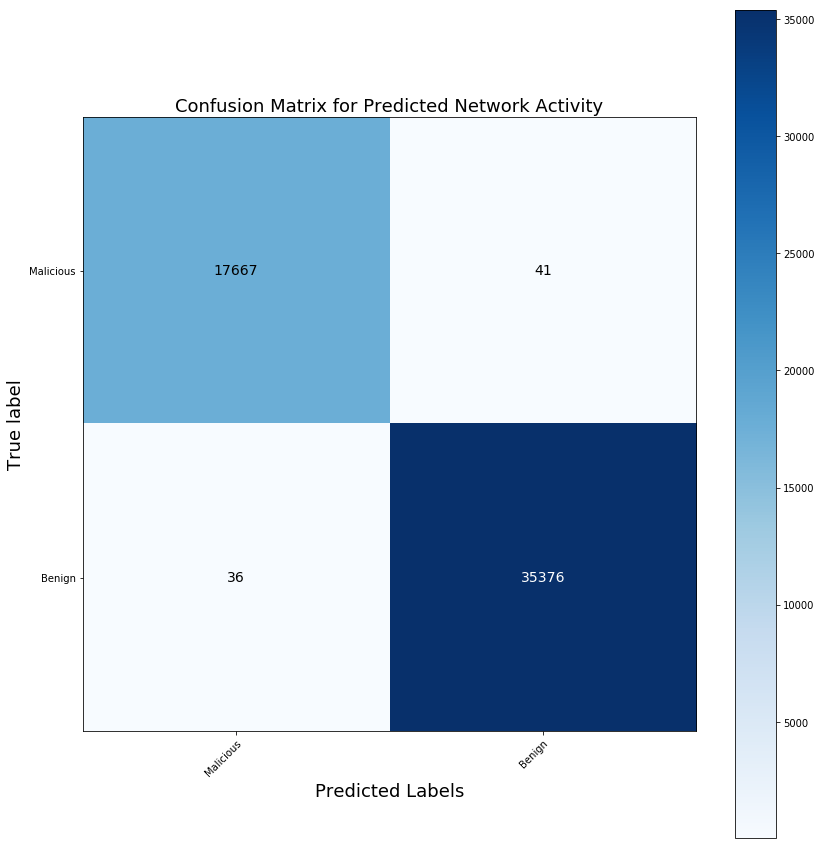

In [0]:
plot_confusion_matrix(n_valid_labels,n_valid_cnn_labels,classes,"WITHOUT-AUTOENCODER")

In [0]:
## Get intermediate output, faster than running eval each time while training
session = tf.Session()
session.run(tf.global_variables_initializer())
intermediate_output_train = []
intermediate_output_test = []
intermediate_output_training = []
intermediate_output_testing = []
with session as sess:
  second_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/CNN_2_'+SCALE_STRING+'.ckpt')
  batch = train_X[:BATCH_SHAPE]
  print(batch.shape)
  intermediate_output_train  = get_rep(batch,full_rep=True)
  print(int(len(train_X)/BATCH_SHAPE))
  for batch_num in range(1,int(len(train_X)/BATCH_SHAPE)):
    batch = train_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    info = get_rep(tf.convert_to_tensor(np.array(batch)),full_rep=True)
    intermediate_output_train  = tf.concat([intermediate_output_train, info],axis = 0)
    if batch_num %100 == 0:
      print(batch_num)
  intermediate_output_training = sess.run(intermediate_output_train) 
f_train_X = intermediate_output_training

In [0]:
## GET AUTO ENCODING 
## Get intermediate output, faster than running eval each time while training
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
with session as sess:
  second_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/CNN_2_'+SCALE_STRING+'.ckpt')
  batch = valid_X[:BATCH_SHAPE]
  intermediate_output_test  = get_rep(batch,full_rep=True)
  print("HELLO")
  for batch_num in range(1,int(len(valid_X)/BATCH_SHAPE)): 
    batch = valid_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    intermediate_output_test  = tf.concat([intermediate_output_test,get_rep(batch,full_rep=True)],axis = 0)
  intermediate_output_testing = sess.run(intermediate_output_test)
f_valid_X = intermediate_output_testing

HELLO


In [0]:
## Fine tune network for training with noisy data
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
x_coord = 0
x_coords = []
accuracies = []
EPOCHS = 5
with session as sess:
  second_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/CNN_2_'+SCALE_STRING+'.ckpt')
  print("Classification Network Benign vs Malicious ")
  for epoch in range(EPOCHS):
    train_acc = 0 
    for batch_num in range(int(len(f_train_X)/BATCH_SHAPE)):
      batch = f_train_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = train_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      current_train_acc = cnn_accuracy.eval(feed_dict={x2_: batch , y2_: batch_label})
      train_acc += current_train_acc      
      cnn_class_train_step.run(feed_dict={x2_:   batch, y2_: batch_label})
    x_coords.append(x_coord)
    accuracies.append(train_acc/(int(len(f_train_X)/BATCH_SHAPE)))
    x_coord+=1
    print('Step %d, training accuracy %g' % (batch_num , train_acc/(int(len(f_train_X)/BATCH_SHAPE))))
    valid_acc = 0 
    for batch_num in range(int(len(f_valid_X)/BATCH_SHAPE)): 
      batch = f_valid_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      valid_acc += cnn_accuracy.eval(feed_dict={x2_:batch, y2_: batch_label})
    print('Step %d, validation accuracy %g' % (batch_num , valid_acc/(int(len(f_valid_X)/BATCH_SHAPE))))     
  print("HERE")
  second_saver.save(sess, './DP-GRAPHS/' + FOLDER+ '/CNN_2_'+SCALE_STRING+'.ckpt')

Classification Network Benign vs Malicious 
Step 4174, training accuracy 0.969227
Step 414, validation accuracy 0.985241
Step 4174, training accuracy 0.973033
Step 414, validation accuracy 0.986672
Step 4174, training accuracy 0.97396
Step 414, validation accuracy 0.986521
Step 4174, training accuracy 0.974813
Step 414, validation accuracy 0.987406
Step 4174, training accuracy 0.97524
Step 414, validation accuracy 0.987538
HERE


In [0]:
## Get labels for the confusion matrix
n_valid_labels = []
n_valid_cnn_labels = []
for label in valid_labels[:53120]:
  n_label = np.argmax(label)
  n_valid_labels.append(n_label)
for label in valid_cnn_labels:
  n_label = np.argmax(label)
  n_valid_cnn_labels.append(n_label)

classes = ["Malicious","Benign"]

Confusion matrix, without normalization
[[17275   433]
 [  233 35179]]


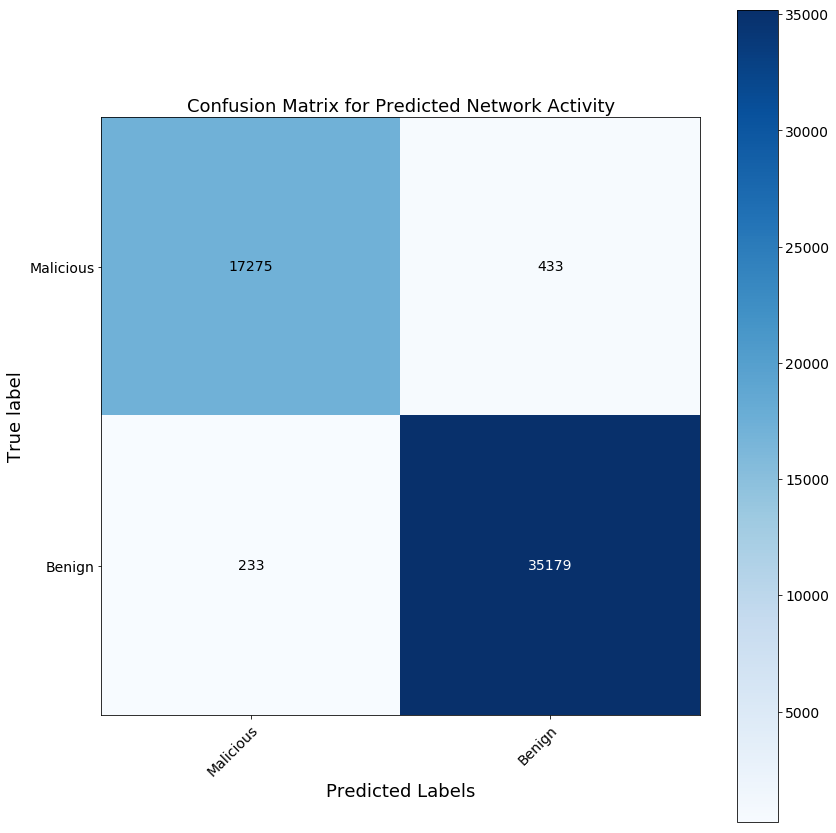

In [0]:
plot_confusion_matrix(n_valid_labels,n_valid_cnn_labels,classes,"AFTER-AUTOENCODER")

In [0]:
## Get valid malicious flows  ##
index = 0 
indices = []
for label in valid_labels:
  if label[0] == 1:
    indices.append(index)
  index+=1
valid_malicious_flows = []
for i in indices:
  valid_malicious_flows.append(valid_X[i])
print(len(valid_malicious_flows))

## Get benign flows ##
index = 0 
for label in valid_labels:
  if label[0] == 0:
    indices.append(index)
  index+=1
valid_benign_flows = []
for i in indices:
  valid_benign_flows.append(valid_X[i])
print(len(valid_benign_flows))

## Get malicious flows for getting adversarial examples ##
adv_labels = len(valid_labels)*[[0,1]]
NUM_SAMPLED = 17664
test_malicious_flows_index = np.random.choice(len(valid_malicious_flows), NUM_SAMPLED , replace=False)
test_malicious_flows = []
for index in test_malicious_flows_index:
  test_malicious_flows.append(valid_malicious_flows[index])
test_malicious_flows = np.array(test_malicious_flows)

17747
53242


In [0]:
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import cleverhans
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.attacks import SparseL1Descent  
from cleverhans.attacks import MomentumIterativeMethod
from cleverhans.attacks import ElasticNetMethod
import cleverhans.model as chm
## Create adversarial examples 
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
with session as sess: 
  second_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/CNN_2_'+SCALE_STRING+'.ckpt')
  with  tf.device('/device:GPU:0'):
    nn_model = chm.CallableModelWrapper(get_logits, 'logits')
    fgsm = SparseL1Descent(nn_model,sess =sess)

    ## ElasticNetMethod ##
#     fgsm_params = {'batch_size':294,
#                    'decision_rule': 'L1',
#                     'beta': 1,
#                     'binary_search_steps':.1,
#                     'initial_const': 0.0001,
#                     'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}



    ## MomentumIterativeMethod ###
  #     fgsm_params = {'eps_iter':0.005,
  #        'eps': 0.1,
  #       'nb_iter': 100,                   
  #       'ord': 1,
  #                    'clip_min': 0,
  #                    'clip_max': 1.,
  #                     'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}

    ## Basic Iterative Method ###
  #     fgsm_params = {'eps_iter':0.005,
  #          'eps': .1,
  #         'nb_iter': 1000,                   
  #         'ord': 1,
  #                      'clip_min': 0,
  #                      'clip_max': 1.,
  #                       'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}

    ### Fast Gradient Descent ###
  #     fgsm_params = {
  #          'eps': 0.2,   
  #         'ord': 1,
  #                      'clip_min': 0,
  #                      'clip_max': 1.,
  #                       'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}

    ### SparseL1 Descent ###
    fgsm_params = {'eps_iter':0.005,
         'eps': SCALE,
        'nb_iter': 100,                   
        'ord': 1,
                     'clip_min': 0,
                     'clip_max': 1.,
                      'y_target': tf.convert_to_tensor(adv_labels[:BATCH_SHAPE])}
    batch = test_malicious_flows[:BATCH_SHAPE]
    adv_x = fgsm.generate(tf.cast(np.array(batch),tf.float32), **fgsm_params)
    first_sample = test_malicious_flows[0]
    for batch_num in range(1,int(len(test_malicious_flows)/BATCH_SHAPE)):
      print(batch_num)
      batch =test_malicious_flows[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_size = len(batch)
      while len(batch)< BATCH_SHAPE:
        batch.append(first_sample) 
      adv_output = fgsm.generate(tf.cast(np.array(batch),tf.float32), **fgsm_params)
      adv_x  = tf.concat([adv_x, adv_output[:batch_size]],axis = 0)

    print("GET ADVERSARIAL EXAMPLES")
    ## Run to get adversarial examples ##
    adversarial_output = sess.run(adv_x)

  print("GET SOFTMAX ADV EXAMPLES")
  ## Run to get adversarial output ##
  batch = adversarial_output[:BATCH_SHAPE]
  adv_soft_output = sess.run(tf.nn.softmax(get_logits(batch)))
  first_sample = adversarial_output[0]
  for batch_num in range(1,int(len(adversarial_output)/BATCH_SHAPE)):
    print(batch_num)
    batch = adversarial_output[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_size = len(batch)
    while len(batch)< BATCH_SHAPE:
      batch.append(first_sample)
    adv_soft_out = tf.nn.softmax(get_logits(batch))
    adv_soft_output = tf.concat([adv_soft_output,adv_soft_out],axis = 0) 
    
  adv_soft_output = sess.run(adv_soft_output) 

In [0]:
session = tf.Session()
session.run(tf.global_variables_initializer())
## Get non-adversarial softmax output ##
with session as sess: 
  second_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/CNN_2_'+SCALE_STRING+'.ckpt')
  batch = test_malicious_flows[:BATCH_SHAPE]
  n_non_adv_soft_output = tf.nn.softmax(get_logits(tf.cast(np.array(batch),tf.float32)))
  first_sample = test_malicious_flows[0]
  print(int(len(test_malicious_flows)/BATCH_SHAPE))
  for batch_num in range(1,int(len(test_malicious_flows)/BATCH_SHAPE)):
    print(batch_num)
    batch = test_malicious_flows[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_size = len(batch)
    while len(batch)< BATCH_SHAPE:
      print("HERE")
      batch.append(first_sample) 
    non_adv_soft_out = tf.nn.softmax(get_logits(tf.cast(np.array(batch),tf.float32)))
    n_non_adv_soft_output = tf.concat([n_non_adv_soft_output,non_adv_soft_out],axis = 0) 
  non_adv_soft_output = sess.run(n_non_adv_soft_output)

In [0]:
import math
differences = []
## Get differences betwen nonadversarial and adversarial examples
for i in range(len(adversarial_output)):
  difference = 0 
  for index in range(len(adversarial_output[i])):
    difference += abs(adversarial_output[i][index]- test_malicious_flows[i][index])
  differences.append(difference)


17664


In [0]:
true_adv_examples = []
true_adv_examples_soft = []
true_adv_example_index = []
## Get actual true adversarial examples ##
for index in range(len(adv_soft_output)):
  if adv_soft_output[index][1] > .5 and non_adv_soft_output[index][1] < .5:
    true_adv_example_index.append(index)
    true_adv_examples.append(adversarial_output[index])
    true_adv_examples_soft.append(adv_soft_output[index])
    

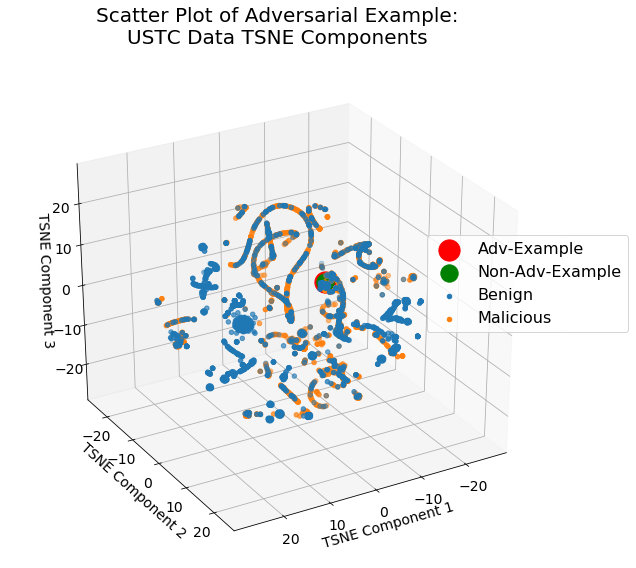

In [0]:
malicious_data_transformed = data_transformed[:NUM_SAMPLED]
benign_data_transformed = data_transformed[NUM_SAMPLED:NUM_SAMPLED+NUM_SAMPLED]
adv_example = data_transformed[NUM_SAMPLED+NUM_SAMPLED:NUM_SAMPLED+NUM_SAMPLED+1]
non_adv_example = data_transformed[NUM_SAMPLED+NUM_SAMPLED+1:]

BENIGN = {0: [x[0] for x in benign_data_transformed],
          1: [x[1] for x in benign_data_transformed],
         2: [x[2] for x in benign_data_transformed]}

MALICIOUS = {0: [x[0] for x in malicious_data_transformed],
          1: [x[1] for x in malicious_data_transformed],
         2: [x[2] for x in malicious_data_transformed]}

ADV_EXAMPLE = {0: [x[0] for x in adv_example],
          1: [x[1] for x in adv_example],
         2: [x[2] for x in adv_example]}

NON_ADV_EXAMPLE = {0: [x[0] for x in non_adv_example],
          1: [x[1] for x in non_adv_example],
         2: [x[2] for x in non_adv_example]}


from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(30, 60)
ax.figure.set_size_inches(10, 9)
_ = ax.scatter(ADV_EXAMPLE[0], ADV_EXAMPLE[1],ADV_EXAMPLE[2], marker='o',c='red',s=450, label="Adv-Example",zorder=2)
_ = ax.scatter(NON_ADV_EXAMPLE[0], NON_ADV_EXAMPLE[1],NON_ADV_EXAMPLE[2], marker='o',c='green',s=300, label="Non-Adv-Example",zorder=5)
_ = ax.scatter(BENIGN[0], BENIGN[1],BENIGN[2], label="Benign",zorder=0)
_ = ax.scatter(MALICIOUS[0], MALICIOUS[1],MALICIOUS[2], label="Malicious",zorder=1)
_ = fig.suptitle('Scatter Plot of Adversarial Example:\nUSTC Data TSNE Components', fontsize=20)
_ = ax.set_xlabel('TSNE Component 1')
_ = ax.set_ylabel('TSNE Component 2')
_ = ax.set_zlabel('TSNE Component 3')
ax.yaxis.label.set_size(14)
ax.xaxis.label.set_size(14)
ax.zaxis.label.set_size(14)
_ = fig.legend(loc='right',fontsize=16)

fig.savefig("./Figures/USTC-adv-example"+NOISE_TYPE+"-"+SCALE_STRING+".pdf", bbox_inches='tight')

In [0]:
# Hoeffding's inequality
# https://en.wikipedia.org/wiki/Hoeffding%27s_inequality
def hoeffding_bound(nobs, alpha, bonferroni_hyp_n=1):
    return math.sqrt(math.log(bonferroni_hyp_n/alpha) / (2*nobs))
def hoeffding_upper_bound(tot_sum, nobs, alpha, bonferroni_hyp_n=1):
    bound = hoeffding_bound(nobs, alpha, bonferroni_hyp_n)
    return tot_sum / nobs + bound
def hoeffding_lower_bound(tot_sum, nobs, alpha, bonferroni_hyp_n=1):
    bound = hoeffding_bound(nobs, alpha, bonferroni_hyp_n)
    return tot_sum / nobs - bound

In [0]:
### Taken from https://github.com/columbia/pixeldp##
def _guaussian_mech_mult(delta):
    return math.sqrt(2 * math.log(1.25 / delta))

def _gaussian_robustness_size(p_max_lb, p_sec_ub, attack_size, dp_epsilon, dp_delta):
    if p_max_lb <= p_sec_ub:
        # we're not even robust to the measurement error...
        return 0.0

    max_r = 0.0
    max_r_eps  = None
    max_r_delt = None
    delta_range = list(np.arange(0.001, 0.3, 0.001))
    #  epsilon_range = list(np.arange(0.1, 1.00000001, 0.001))  # we want 1 included
    for delta in delta_range:
        eps_min, eps_max, eps = (0.0, 1.0, 0.5)
        while eps_min < eps and eps_max >= eps:
        #  for eps in epsilon_range:
            l = attack_size *  \
                (eps / dp_epsilon) *  \
                (_guaussian_mech_mult(dp_delta) / _guaussian_mech_mult(delta))
            if p_max_lb >= math.e ** (2 * eps) * p_sec_ub + (1 + math.e ** eps) * delta:
                if l > max_r:
                    max_r = l
                    max_r_eps = eps
                    max_r_delt = delta
                # best eps for this delta may be bigger
                eps_min = eps
                eps = (eps_min + eps_max) / 2.0
            else:
                # eps is too big for delta
                eps_max = eps
                eps = (eps_min + eps_max) / 2.0

            if eps_max - eps_min < 0.001:
                break

    return max_r

In [0]:
def _laplace_robustness_size(p_max_lb, p_sec_ub, attack_size, dp_epsilon):
    if p_max_lb <= p_sec_ub:
        # we're not even robust to the measurement error...
        return 0.0

    return attack_size * math.log(p_max_lb/p_sec_ub) / (2 * dp_epsilon)

In [0]:
def robustness_size_softmax(softmax_sums,counts):
  n = sum(counts)
  if n == 1:
    return 0
  hyp_n = len(counts)
  num_labels = len(counts)
  i2, i1 = np.argsort(softmax_sums)[-2:]
  p_max_lb = hoeffding_lower_bound(softmax_sums[i1], n, eta, bonferroni_hyp_n=hyp_n)
  p_sec_ub =  hoeffding_upper_bound(softmax_sums[i2], n, eta, bonferroni_hyp_n=hyp_n)
  if NOISE_TYPE == 'laplace':
    return _laplace_robustness_size(p_max_lb, p_sec_ub, SCALE, EPSILON)
  elif NOISE_TYPE == 'gaussian':
    return _gaussian_robustness_size(p_max_lb, p_sec_ub, SCALE, EPSILON, DELTA_DP)

In [0]:
## Make a prediction based on input samples
def predict(sess,samples):
  num_predict = len(samples)
  first_sample = samples[0]
  if num_predict % BATCH_SHAPE != 0:
    for i in range(BATCH_SHAPE-(num_predict % BATCH_SHAPE)):
      samples.append(first_sample)
  batch = samples[:BATCH_SHAPE]
  predictions = tf.nn.softmax(get_logits(tf.cast(np.array(batch),tf.float32)))
  for batch_num in range(1,int(len(samples)/BATCH_SHAPE)):
    batch = samples[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    output = tf.nn.softmax(get_logits(tf.cast(np.array(batch),tf.float32)))
    predictions  = tf.concat([predictions, output],axis = 0)
  prediction_output = sess.run(predictions)
  return prediction_output[:num_predict]

In [0]:
### Perform test for the malicious flow ##
from operator import add
TRAIN = False
softmax_total = [[0.0,]*NUM_CLASS]*len(test_malicious_flows)
counts = [[0,]*NUM_CLASS]*len(test_malicious_flows)
ITERATIONS = 40
session = tf.Session()
session.run(tf.global_variables_initializer())
with session as sess: 
  second_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/CNN_2_'+SCALE_STRING+'.ckpt')
  for i in range(ITERATIONS):
    outputs = predict(session,test_malicious_flows)
    for index in range(len(outputs)): 
      softmax_total[index] = list( map(add, softmax_total[index], outputs[index]))
      answer = np.argmax(outputs[index])
      add_list = [0]*NUM_CLASS
      add_list[answer]+=1
      counts[index] = list( map(add, counts[index], add_list))

In [0]:
eta = .95
robustness = []
for i in range(len(softmax_total)):
  robustness.append(robustness_size_softmax(softmax_total[i],counts[i]))

In [0]:
true_robustness = []
## Get robustness of correctly predicted examples ##
for index in range(len(robustness)):
  if counts[index][0] > counts[index][1]:
    true_robustness.append(robustness[index])

In [0]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(true_robustness, 10)
ax.set_xlabel('Minimum L1 Change')
ax.set_ylabel('Number of Test Malicious Flows')
ax.set_title('Robustness to Adversarial Examples \n After '+ str(ITERATIONS) +' Predictions With Failure Probailiy =' + str(0.05),fontsize=18)
ax.yaxis.label.set_size(16)
ax.xaxis.label.set_size(16)
fig.savefig("./Figures/Robustness"+str(ITERATIONS)+"-"+FOLDER+SCALE_STRING+".pdf", bbox_inches='tight')
